In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1232)
np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [2]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom,uniform
from scipy.special import comb
from scipy.stats import binom, bernoulli

In [3]:
from keras.datasets import mnist

2024-09-13 18:00:14.732854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 18:00:14.950783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/watson/.mujoco/mujoco210/bin:/usr/lib/nvidia
2024-09-13 18:00:14.950819: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-13 18:00:15.024888: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registere

In [4]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = np.where(train_X>0.5,1,0)

In [5]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [117]:
n = 60
m = n *3
sz = 28

tol = 0.01
max_iter = 100
phi = [0.33,0.33,0.33]
elbo_old = -1000

In [118]:
x = np.array([train_X[np.where(train_y==1)[0][0:n],:,:],
                train_X[np.where(train_y==9)[0][0:n],:,:],
                train_X[np.where(train_y==2)[0][0:n],:,:]])
x = x.reshape(m,sz*sz,order='C')


(180, 28, 28)


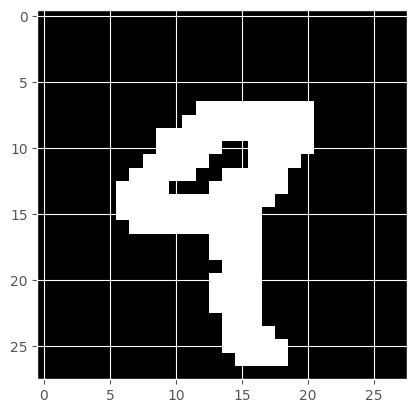

In [91]:
# for i in range(3):  
#     ax = plt.subplot(1,3,i+1)
#     ax.imshow(x[i,i], cmap=plt.get_cmap('gray'))
# plt.show()
dummy = x.reshape(m,sz,sz,order='C')
print(dummy.shape)
plt.imshow(dummy[60,:],cmap=plt.get_cmap('gray'))

In [119]:
uni_model = uniform(loc=0.25,scale=0.5)
thetas = np.array([uni_model.rvs(size=sz*sz),
                   uni_model.rvs(size=sz*sz),
                   uni_model.rvs(size=sz*sz)])
dummy = np.sum(thetas,axis=1)
thetas = thetas/dummy[:,np.newaxis]


In [77]:
print(x.shape)
print(thetas.shape)

(180, 784)
(3, 784)


In [87]:
ll_1 =  np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x) + np.log(phi[0])
ll_2 =  np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x) + np.log(phi[1])
ll_3 =  np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-x) + np.log(phi[2])

ll_1 =  np.nan_to_num(ll_1)+0.0001
ll_2 =  np.nan_to_num(ll_2)+0.0001
ll_3 =  np.nan_to_num(ll_3)+0.0001

denom = np.exp(ll_1) + np.exp(ll_2) + np.exp(ll_3)
w_1 = np.exp(ll_1)/denom
w_2 = np.exp(ll_2)/denom
w_3 = np.exp(ll_3)/denom

thetas[0,:] = np.sum(w_1 * x,axis=0)/np.sum(w_1,axis=0)
thetas[1,:] = np.sum(w_2 * x,axis=0)/np.sum(w_2 ,axis=0)
thetas[2,:] = np.sum(w_2 * x,axis=0)/np.sum(w_2,axis=0)
phi[0] = np.sum(w_1)/m/784
phi[1] = np.sum(w_2)/m/784
phi[2] = np.sum(w_3)/m/784

/tmp/ipykernel_3718268/459035256.py:1: RuntimeWarning: divide by zero encountered in log
  ll_1 =  np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x) + np.log(phi[0])
/tmp/ipykernel_3718268/459035256.py:1: RuntimeWarning: invalid value encountered in multiply
  ll_1 =  np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x) + np.log(phi[0])
/tmp/ipykernel_3718268/459035256.py:2: RuntimeWarning: divide by zero encountered in log
  ll_2 =  np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x) + np.log(phi[1])
/tmp/ipykernel_3718268/459035256.py:2: RuntimeWarning: invalid value encountered in multiply
  ll_2 =  np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x) + np.log(phi[1])
/tmp/ipykernel_3718268/459035256.py:3: RuntimeWarning: divide by zero encountered in log
  ll_3 =  np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-x) + np.log(phi[2])
/tmp/ipykernel_3718268/459035256.py:3: RuntimeWarning: invalid value encountered in multiply
  ll_3 =  np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-

In [120]:
for i in range(max_iter):

    ll_1 =  np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x) + np.log(phi[0])
    ll_2 =  np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x) + np.log(phi[1])
    ll_3 =  np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-x) + np.log(phi[2])

    ll_1 =  np.nan_to_num(ll_1)+0.0001
    ll_2 =  np.nan_to_num(ll_2)+0.0001
    ll_3 =  np.nan_to_num(ll_3)+0.0001

    denom = np.exp(ll_1) + np.exp(ll_2) + np.exp(ll_3)
    w_1 = np.exp(ll_1)/denom
    w_2 = np.exp(ll_2)/denom
    w_3 = np.exp(ll_3)/denom

    elbo = np.sum(w_1 * ll_1 + w_2 * ll_2 + w_3 * ll_3)

    thetas[0,:] = np.sum(w_1 * x,axis=0)/np.sum(w_1 * m,axis=0)
    thetas[1,:] = np.sum(w_2 * x,axis=0)/np.sum(w_2 * m,axis=0)
    thetas[2,:] = np.sum(w_3 * x,axis=0)/np.sum(w_3 * m,axis=0)

    phi[0] = np.sum(w_1)/m
    phi[1] = np.sum(w_2)/m
    phi[2] = np.sum(w_3)/m

    print(f"Iteration: {i}")
    print(f"ELBO is: {elbo}")
    if np.abs(elbo-elbo_old) < tol:
        break
    elbo_old = elbo

Iteration: 0
ELBO is: -314358.75108461047
Iteration: 1
ELBO is: 374820.0392942091
Iteration: 2
ELBO is: 374893.3614191095
Iteration: 3
ELBO is: 374895.0286316538
Iteration: 4
ELBO is: 374889.1196007774
Iteration: 5
ELBO is: 374883.45750494034
Iteration: 6
ELBO is: 374878.90440884535
Iteration: 7
ELBO is: 374875.3314806292
Iteration: 8
ELBO is: 374872.50979438407
Iteration: 9
ELBO is: 374870.250019859
Iteration: 10
ELBO is: 374868.4126135222
Iteration: 11
ELBO is: 374866.89705071255
Iteration: 12
ELBO is: 374865.63063475426


/tmp/ipykernel_3718268/241359230.py:3: RuntimeWarning: divide by zero encountered in log
  ll_1 =  np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x) + np.log(phi[0])
/tmp/ipykernel_3718268/241359230.py:3: RuntimeWarning: invalid value encountered in multiply
  ll_1 =  np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x) + np.log(phi[0])
/tmp/ipykernel_3718268/241359230.py:4: RuntimeWarning: divide by zero encountered in log
  ll_2 =  np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x) + np.log(phi[1])
/tmp/ipykernel_3718268/241359230.py:4: RuntimeWarning: invalid value encountered in multiply
  ll_2 =  np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x) + np.log(phi[1])
/tmp/ipykernel_3718268/241359230.py:5: RuntimeWarning: divide by zero encountered in log
  ll_3 =  np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-x) + np.log(phi[2])
/tmp/ipykernel_3718268/241359230.py:5: RuntimeWarning: invalid value encountered in multiply
  ll_3 =  np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-

Iteration: 13
ELBO is: 374864.5601032334
Iteration: 14
ELBO is: 374863.6458065278
Iteration: 15
ELBO is: 374862.8577470592
Iteration: 16
ELBO is: 374862.17287872906
Iteration: 17
ELBO is: 374861.57324501313
Iteration: 18
ELBO is: 374861.0446759708
Iteration: 19
ELBO is: 374860.5758614456
Iteration: 20
ELBO is: 374860.1576810175
Iteration: 21
ELBO is: 374859.78271194856
Iteration: 22
ELBO is: 374859.4448625263
Iteration: 23
ELBO is: 374859.1390951568
Iteration: 24
ELBO is: 374858.8612146707
Iteration: 25
ELBO is: 374858.60770469316
Iteration: 26
ELBO is: 374858.375599896
Iteration: 27
ELBO is: 374858.1623853683
Iteration: 28
ELBO is: 374857.9659166985
Iteration: 29
ELBO is: 374857.7843560363
Iteration: 30
ELBO is: 374857.6161205931
Iteration: 31
ELBO is: 374857.4598409008
Iteration: 32
ELBO is: 374857.31432678486
Iteration: 33
ELBO is: 374857.1785394784
Iteration: 34
ELBO is: 374857.05156865006
Iteration: 35
ELBO is: 374856.93261339335
Iteration: 36
ELBO is: 374856.8209664192
Iteration:

In [ ]:
ll_1 =  np.sum(np.log(thetas[0,:])*x + np.log(1-thetas[0,:])*(1-x),axis=1)+ np.log(phi[0])
ll_2 =  np.sum(np.log(thetas[1,:])*x + np.log(1-thetas[1,:])*(1-x),axis=1)+ np.log(phi[1])
ll_3 =  np.sum(np.log(thetas[2,:])*x + np.log(1-thetas[2,:])*(1-x),axis=1)+ np.log(phi[2])

In [ ]:
denom = np.exp(ll_1) + np.exp(ll_2) + np.exp(ll_3)
w_1 = np.exp(ll_1)/denom
w_2 = np.exp(ll_2)/denom
w_3 = np.exp(ll_3)/denom

In [ ]:
print(thetas.shape)
dummy = thetas.reshape(3,28,28)
plt.imshow(dummy[0,:])

In [109]:
thetas[0]

array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001,
       0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.002,
       0.002, 0.002,

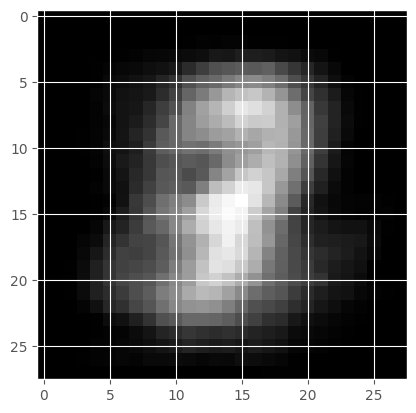

In [121]:
test = thetas.reshape(3,28,28)
plt.imshow(test[2,:],cmap=plt.get_cmap('gray'))